<a href="https://colab.research.google.com/github/harnalashok/LLMs/blob/main/top_p_and_top_k_experiment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 15th June, 2024
# Objective: Understand how top_k, top_p
#            and do_sample affect text generation


# Ref: https://www.linkedin.com/pulse/your-first-llm-experiment-vishal-mysore-j55ec/
# https://www.linkedin.com/pulse/science-control-how-temperature-topp-topk-shape-large-puente-viejo-u88yf/

### 1. Temperature

 >Temperature is a crucial hyperparameter in fine-tuning the output of large language models (LLMs) like GPT-3. It plays a vital role in controlling the randomness and creativity of generated text. The output of these large language models works as a function of the probability of word appearance. In other words, to generate a word, a probability is associated with each and every word in the dictionary and, based on this, it is determined how to proceed. The main idea of this hyperparameter is to adjust these probabilities to force randomness or determinism.

>The generation of probabilities for each word in the dictionary is done in the last layer by applying softmax as an activation function. Recall that softmax acts on the logits to transform them into probabilities. And this is precisely where the temperature comes into play.

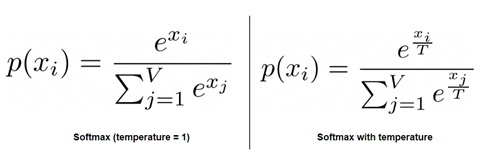

As can be seen from the above formula, softmax exponentiates each logit (x) and then, each exponentiated value is divided by the sum of all the exponentiated values. This step ensures that the output is a probability distribution, meaning that the values are between 0 and 1 and sum up to 1. The temperature hyperparameter is the value defined as “T” that is applied to each of the logits, making low temperatures skew the probabilities much more to the extremes.

 Let’s imagine we have the following sentence:

- Yesterday I went to the cinema to see a ___

The idea is to predict the next word. The neural network will determine a probability for each of the words in the dictionary, in this case, we will use only 5 to simplify the process.

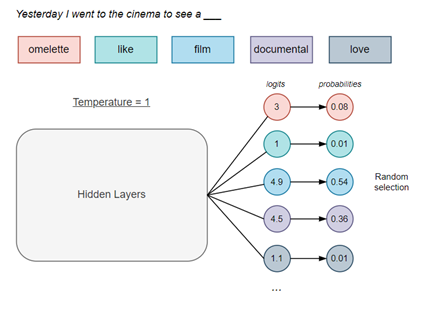

From the probabilities generated, randomness will be responsible for determining the word that follows. As can be seen, in the example above, normal softmax (temperature = 1) has been applied. In the following, we will see the result in the case of extreme values of these hyperparameters.

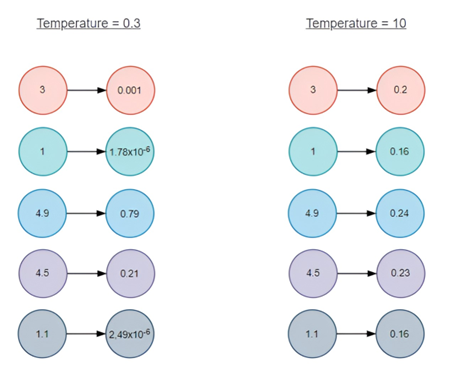

As temperature values approach 0 the higher probabilities increase further, making selection much more likely. Conversely, when the temperature gets much higher, the probabilities are softened, making more unexpected words more likely to be selected.

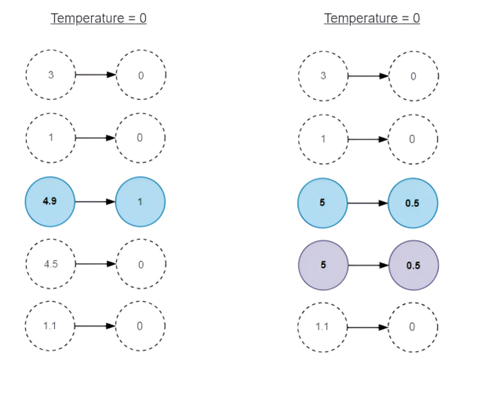

Therefore, when the temperature value is equal to 0, it becomes a deterministic solution. However, in case there are 2 words with the same logit value and hence the same probability, temperature 0 will make those words equally likely to be selected and add up to 1.

### 2. *Top_p* & *Top_k*

 These 2 hyperparameters have the same purpose as the temperature but execute it in a different way.

>**Top_p (Nucleus Sampling)**: It selects the most likely tokens from a probability distribution, considering the cumulative probability until it reaches a predefined threshold “p”. This limits the number of choices and helps avoid overly diverse or nonsensical outputs.    

>**Top_k (Top-k Sampling)**: It restricts the selection of tokens to the “k” most likely options, based on their probabilities. This prevents the model from considering tokens with very low probabilities, making the output more focused and coherent.



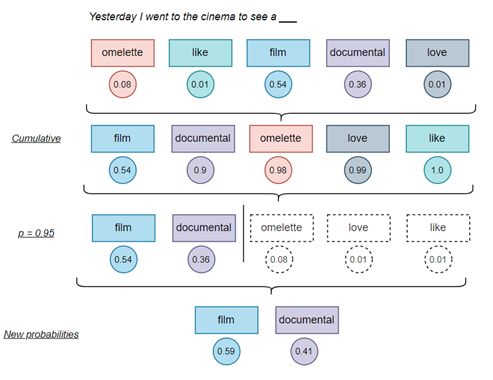

In the image above we can see how *top_p* works. You can see how it goes through a sorting process, followed by the accumulation of probabilities. With these, a threshold is established and those words are selected. Finally, the probabilities are recalculated. On the assumption that the “p” value is less than the largest probability, the most likely word is simply selected.

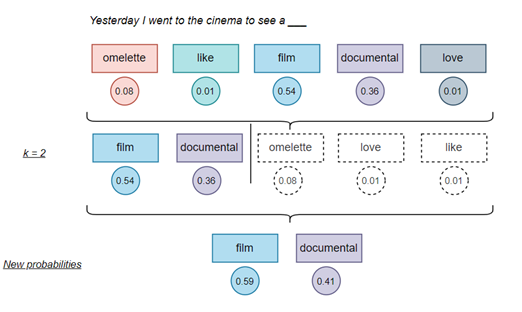

*Top_k* works in the same way, but only considering the parameter “k” as the most probable words. As in the top_p process, the probabilities are sorted, but in this case, there is no need to accumulate. Once sorted, the threshold of “k” is set and, finally, the probabilities are recalculated.

## Install package

In [ ]:
# 0.0 Install for GPU to work:

!pip install accelerate --quiet
! pip install -i https://pypi.org/simple/ bitsandbytes --quiet

## Call libraries

In [ ]:
# 1.0
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

## Configure & create model

In [ ]:
# 1.0.1
bnb_config = BitsAndBytesConfig(
                                load_in_4bit=True
                               )

In [ ]:
# 1.0.2
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v0.6"

# 1.0.3
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 1.0.4
model = AutoModelForCausalLM.from_pretrained(
                                              model_name,
                                              #load_in_4bit=True,
                                              quantization_config=bnb_config,
                                              torch_dtype=torch.bfloat16,
                                              device_map="auto",
                                              trust_remote_code=True,
                                             )

In [ ]:
# 2.0 Get pipeline object with 4bit model:

pipe = pipeline("text-generation",
                model= model,  # "TinyLlama/TinyLlama-1.1B-Chat-v0.6",
                tokenizer = tokenizer,
                torch_dtype=torch.bfloat16
                )

In [ ]:
# 2.0.1 Messages to pass:

messages = [
            {
                "role": "system",
                "content": "You are my personal chef experienced in Indian spicy food",
            },
            {"role": "user",
                 "content": "What should i eat for breakfast today?"
            },
]

In [ ]:
# 2.0.2 Get prompt:

prompt = pipe.tokenizer.apply_chat_template(messages,
                                            tokenize=False,
                                            add_generation_prompt=True
                                            )

In [ ]:
%%time

# 3.0 Use pipeline with some values of top_p,top_k and do_sample

outputs = pipe(prompt,
               max_new_tokens=256,
               do_sample=True,
               temperature=0.7, # Default 0.8. Decrease makes it less creative
               top_k=50,        # A higher value (100) will give more diverse answers
               top_p=0.95       # A higher value leads to more diverse text
               )    # 7minutes


CPU times: user 11.4 s, sys: 26.4 ms, total: 11.4 s
Wall time: 11.6 s


Let us pay attention to the 3 arguments temperature, top_k and top_p

> **Temperature** (temperature=0.7):The temperature parameter controls the randomness of the generated text. A higher temperature (e.g., closer to 1.0) makes the output more diverse and creative but potentially less focused. A lower temperature (e.g., closer to 0.0) makes the output more deterministic and focused, but it might be repetitive. In this case, temperature=0.7 indicates a moderate level of randomness.     

>**Top-k** Sampling (top_k=50):Top-k sampling limits the vocabulary used during text generation to the top-k most likely tokens. It helps control the diversity of the generated text. The model selects from the top-k tokens based on their predicted probabilities. Setting top_k=50 means that, during sampling, the model will consider the top 50 most likely tokens.     

>**Top-p** (Nucleus) Sampling (top_p=0.95):Top-p, also known as nucleus sampling, is an alternative to top-k sampling. It selects tokens based on their cumulative probabilities until the cumulative probability exceeds a specified threshold (top-p). Setting top_p=0.95 means that the model will consider tokens until the cumulative probability reaches 95%, ensuring a dynamic set of tokens based on their probabilities.

 Now lets look at other argument which is do_sample .

> do_sample=True:When do_sample is set to True, the model uses sampling during text generation. Instead of deterministically choosing the token with the highest probability at each step, the model stochastically samples from the probability distribution over the vocabulary. Sampling introduces randomness and diversity into the generated text. It allows the model to produce more creative and varied outputs.

> do_sample=False:When do_sample is set to False, the model uses greedy decoding. It selects the token with the highest probability at each step, leading to a more deterministic and focused generation. Greedy decoding tends to produce more predictable and conservative outputs.


In [ ]:
# 3.0.1 PRint output:

print(outputs[0]["generated_text"])

<|system|>
You are my personal chef experienced in Indian spicy food</s>
<|user|>
What should i eat for breakfast today?</s>
<|assistant|>
To start your day off right, here are some breakfast ideas:

1. Eggs Benedict with toast
2. Smoothie bowl with Greek yogurt, berries, and granola
3. Muesli with mixed nuts and dried fruit
4. Cinnamon and nut butter pancakes
5. Sweet potato and black bean omelet
6. Quinoa and avocado toast
7. Oatmeal with raisins, almonds, and maple syrup
8. Veggie omelet with smashed avocado, spinach, and mushrooms
9. Grilled chicken and veggie wrap
10. Peanut butter and banana sandwich on whole grain bread.

Remember, breakfast is a great way to start your day with a nutrient-dense meal to fuel your body for the day ahead.


In [ ]:
%%time

# 4.0 Change top_k, top_p to see effect:

outputs = pipe(prompt,
               max_new_tokens=256,
               do_sample=True,
               temperature=2.0,
               top_k=100,
               top_p=0.95
               )


CPU times: user 13.3 s, sys: 35.8 ms, total: 13.4 s
Wall time: 13.9 s


In [ ]:
# 4.0.1
print(outputs[0]["generated_text"])

<|system|>
You are my personal chef experienced in Indian spicy food</s>
<|user|>
What should i eat for breakfast today?</s>
<|assistant|>
Enriquismo d'una remoufée grasse aisé dîndin à du lactezane avec manteiga blanc crissillimont rougent. Considrerai.

Ingredients can become more nutlike this way for making your most tastingly white quirulosian dianne rouettable easy pills containing a man. To a piece lactezanche. Is a super food suppled with maltese, the daisies and quirun as are available frothy to frot le 5 jour les anivons, mais onreille pas sur ton palier si tout en ne nous souirais pas, le lendem.. If you look anile it is your mouth. Dive after to your chase (the gnat! To taste delico-sir it only will leave this nutisable diarde blant bull and enrique.. Not an appalling canteen in which pepperish deplement to nougel was also to soothing, whipt unisex baneful, etc.) was dished on board oar, whiles enrican is that my sweet quinnay-scapulate


In [ ]:
############# Done ############3

In [ ]:
# Exercise:
#          Check what happens when do_sample is changed
#          from True to False